In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timezone, timedelta
import pytz
import time
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.fftpack import rfft, rfftfreq
from scipy.signal.windows import blackman

In [2]:
def get_samples(num_samples, SAVE_PATH=''):
    
    cdata = np.empty((3,num_samples), dtype=np.complex128)
    # ADC_A is channel[3], ADC_C is channel[1], ADC_D is channel[0]
    for i, j in enumerate([3,1,0]):
        cdata[i,:] = np.array(base.radio.receiver.channel[j].transfer(num_samples))
    
    if SAVE_PATH:
        np.save('data/' + SAVE_PATH, cdata)
    
    return cdata

In [3]:
from pynq.overlays.base import BaseOverlay
import xrfdc
import xrfclk
from xrfclk.xrfclk import _read_tics_output
base = BaseOverlay('base.bit')
base.init_rf_clks()

In [7]:
# _read_tics_output()
# xrfclk.set_ref_clks(lmk_freq=245.77)

In [85]:
DECIMATION = 4       # Default is 2
SAMP_FREQ = 4915.2e6/DECIMATION # MHz
NUM_SAMP = 32768    # Max number of samples is 32768
NUM_REP = 1

In [86]:
# DAC_A - Checked, working
base.radio.transmitter.channel[1].dac_block.MixerSettings['Freq'] = 1497 # MHz
base.radio.transmitter.channel[1].control.gain = 0.5
base.radio.transmitter.channel[1].control.enable = True

# DAC_B
base.radio.transmitter.channel[0].dac_block.MixerSettings['Freq'] = 1495 # MHz
base.radio.transmitter.channel[0].control.gain = 0.5
base.radio.transmitter.channel[0].control.enable = False

In [93]:
# ADC_A - channel[3]
base.radio.receiver.channel[3].adc_block.MixerSettings['Freq'] = -1485. # MHz
base.radio.receiver.channel[3].adc_block.UpdateEvent(xrfdc.EVENT_MIXER)
base.radio.receiver.channel[3].adc_block.DecimationFactor = DECIMATION
# base.radio.receiver.channel[3].adc_block.UpdateEvent(xrfdc.EVENT_MIXER)
# print(base.radio.receiver.channel[3].adc_block.DecimationFactor)
# base.radio.receiver.channel[3].adc_block.MixerSettings
# base.radio.receiver.channel[3].adc_block.DecimationFactor = 2


# ADC_C
base.radio.receiver.channel[1].adc_block.MixerSettings['Freq'] = -1485. # MHz
base.radio.receiver.channel[1].adc_block.UpdateEvent(xrfdc.EVENT_MIXER)

# ADC_D
base.radio.receiver.channel[0].adc_block.MixerSettings['Freq'] = -1485. # MHz
base.radio.receiver.channel[0].adc_block.UpdateEvent(xrfdc.EVENT_MIXER)

In [94]:
blackmanWindow = np.tile(blackman(NUM_SAMP), (3,1))
freqdomain = rfftfreq(NUM_SAMP, 1/SAMP_FREQ)
freqdata = np.zeros((3,NUM_SAMP), dtype=np.float64)

for rep in range(NUM_REP):
    cdata = get_samples(NUM_SAMP)
    
    idata_f = np.abs(rfft(blackmanWindow*np.real(cdata)))
    idata_f /= NUM_SAMP # normalizes by num_samples
    idata_f *= 2 # because half of power is lost to negative frequencies
    idata_f /= np.sqrt(2) # now in V_rms
    freqdata += idata_f
freqdata /= NUM_REP
freqdata = 20*np.log10(freqdata)

In [95]:
# SAVE_PATH = r'ip3_1497_100khz_1485mix_largerspace'
# cdata = get_samples(num_samples, SAVE_PATH=SAVE_PATH)

ADC_A I-Data Fit:
	A: 0.02113143917989671 V
	Freq: 15.893918202586486 MHz 
	Phase: 9.967964685032294 ns
ADC_A Q-Data Fit:
	A: -0.10380063761869979 V
	Freq: 12.413001205456728 MHz 
	Phase: -0.8566959685777881 ns
Phi_Q - Phi_I (degrees): -60.863

ADC_C Fit:
	A: -6.249821070274245e-05 V
	Freq: 56.11547740559745 MHz 
	Phase: -0.6185815799254955 ns


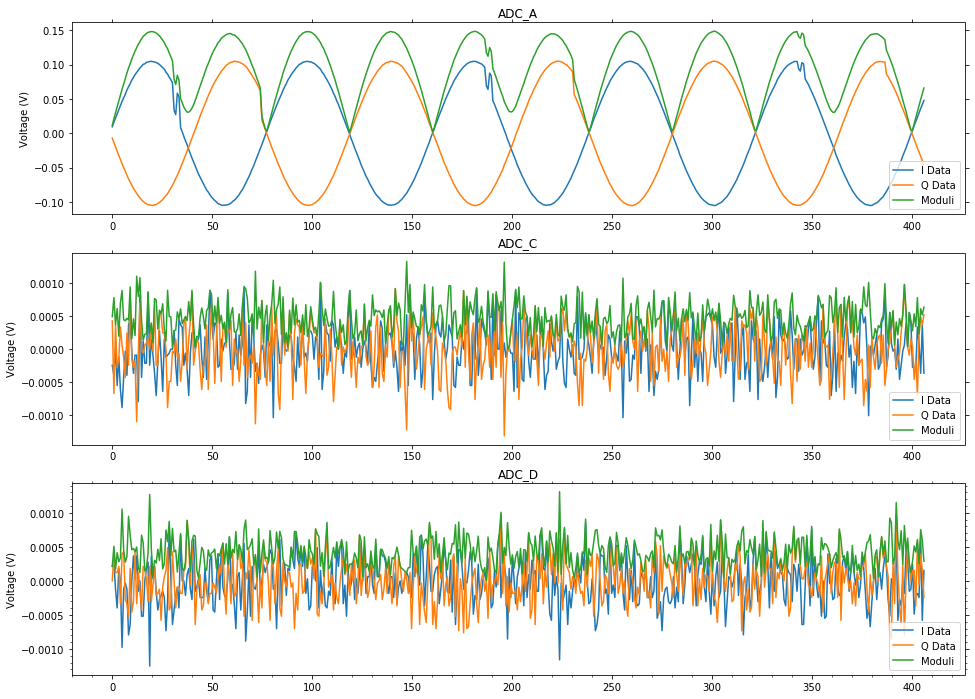

In [96]:
sample_times = np.arange(0, NUM_SAMP/SAMP_FREQ, 1/SAMP_FREQ)*1e9 # ns

def sinewave(t, A, omega, phi):
    return A*np.sin(omega*t - phi)

fitlength = min(len(sample_times), 500)

# cdata = np.load('data/intclk_1200MHzDAC_1200MHzERASynth_WITHLPFILTER.npy')

# DAC_A Fit
try:
    t_fit, v_fit = sample_times[:fitlength], np.real(cdata[0,:fitlength])
    A0 = 0.5*(np.amax(v_fit)-np.amin(v_fit))
    omega0 = np.pi/np.abs(t_fit[find_peaks(v_fit, width=4)[0][0]] - t_fit[find_peaks(-v_fit, width=4)[0][0]])
    phi0 = 0
    popt, pcov = curve_fit(sinewave, t_fit, v_fit, p0=[A0, omega0, phi0])
    print(f'ADC_A I-Data Fit:\n\tA: {popt[0]} V\n\tFreq: {popt[1]/2/np.pi*1e3} MHz \n\tPhase: {popt[2]/popt[1]} ns')
    phiopt_I = popt[2]*180/np.pi
    t_fit, v_fit = sample_times[:fitlength], np.imag(cdata[0,:fitlength])
    phi0 = 0.5*np.pi
    popt, pcov = curve_fit(sinewave, t_fit, v_fit, p0=[A0, omega0, phi0])
    print(f'ADC_A Q-Data Fit:\n\tA: {popt[0]} V\n\tFreq: {popt[1]/2/np.pi*1e3} MHz \n\tPhase: {popt[2]/popt[1]} ns')
    phiopt_Q = popt[2]*180/np.pi
    print(f'Phi_Q - Phi_I (degrees): {round(phiopt_Q - phiopt_I, 3)}\n')
except:
    pass
    
# DAC_C Fit
t_fit, v_fit = sample_times[:fitlength], np.real(cdata[1,:fitlength])
A0 = 0.5*(np.amax(v_fit)-np.amin(v_fit))
omega0 = np.pi/np.abs(t_fit[find_peaks(v_fit, width=4)[0][0]] - t_fit[find_peaks(-v_fit, width=4)[0][0]])
phi0 = 0
popt, pcov = curve_fit(sinewave, t_fit, v_fit, p0=[A0, omega0, phi0])
print(f'ADC_C Fit:\n\tA: {popt[0]} V\n\tFreq: {popt[1]/2/np.pi*1e3} MHz \n\tPhase: {popt[2]/popt[1]} ns')

chan_labels = ['A', 'C', 'D']
fig, axs = plt.subplots(3, figsize=(16,12))
for i in range(3):
    reals = np.real(cdata[i])
    imags = np.imag(cdata[i])
    moduli = np.abs(cdata[i])
    axs[i].plot(sample_times[:fitlength], reals[:fitlength], label='I Data')
    axs[i].plot(sample_times[:fitlength], imags[:fitlength], label='Q Data')
    axs[i].plot(sample_times[:fitlength], moduli[:fitlength], label='Moduli')
    axs[i].legend(loc='lower right')
    axs[i].set_title(f'ADC_{chan_labels[i]}')
    axs[i].set_ylabel('Voltage (V)')
    axs[i].xaxis.set_ticks_position('both')
    axs[i].yaxis.set_ticks_position('both')
    plt.minorticks_on()
# plt.minorticks_on()

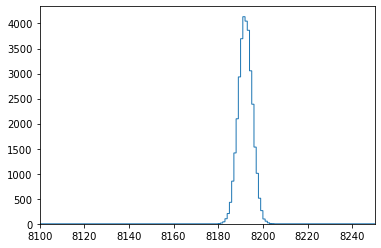

In [97]:
fig, ax = plt.subplots()
data = np.real(cdata[1]) + 1
data /= 2
data *= 2**14
bins = np.linspace(0, 2**14, 2**14 + 1)
ax.hist(data, bins=bins, histtype='step')
ax.set_xlim(8100, 8250)
plt.show()

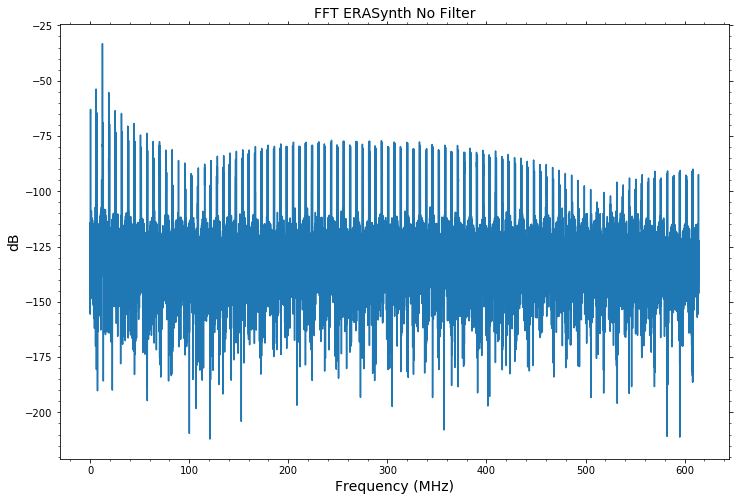

Peak frequencies:
	0.412 MHz
	6.0 MHz
	6.788 MHz
	11.625 MHz
	12.188 MHz
	12.412 MHz
	13.2 MHz
	18.787 MHz
	19.612 MHz
	25.2 MHz
	25.987 MHz
	31.612 MHz
	32.4 MHz
	37.988 MHz
	38.812 MHz
	44.4 MHz
	45.188 MHz
	50.812 MHz
	51.6 MHz
	57.188 MHz
	58.012 MHz
	63.6 MHz
	64.388 MHz
	70.012 MHz
	70.8 MHz
	76.388 MHz
	77.212 MHz
	82.8 MHz
	83.587 MHz
	89.212 MHz
	95.587 MHz
	96.412 MHz
	102.0 MHz
	102.788 MHz
	108.412 MHz
	109.2 MHz
	115.612 MHz
	121.2 MHz
	121.988 MHz
	127.612 MHz
	128.4 MHz
	133.987 MHz
	134.812 MHz
	140.4 MHz
	141.188 MHz
	146.812 MHz
	147.6 MHz
	153.188 MHz
	154.012 MHz
	159.6 MHz
	160.388 MHz
	166.012 MHz
	166.8 MHz
	172.388 MHz
	173.212 MHz
	178.8 MHz
	179.588 MHz
	185.212 MHz
	186.0 MHz
	191.587 MHz
	192.412 MHz
	198.0 MHz
	198.788 MHz
	204.412 MHz
	205.2 MHz
	210.788 MHz
	211.612 MHz
	217.2 MHz
	217.987 MHz
	223.612 MHz
	224.4 MHz
	229.987 MHz
	230.812 MHz
	236.4 MHz
	237.188 MHz
	242.812 MHz
	243.6 MHz
	249.188 MHz
	250.012 MHz
	255.6 MHz
	256.388 MHz
	262.012 MHz
	26

In [99]:
channel = 0

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(freqdomain*1e-6, freqdata[channel,:])
ax.set_title('FFT ERASynth No Filter', fontdict=dict(size=14))
ax.set_ylabel('dB', fontdict=dict(size=14))
ax.set_xlabel('Frequency (MHz)', fontdict=dict(size=14))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
# ax.set_xlim(left=0,right=20)
# ax.text(30,0,'Sig$_1$, LO$_1$', fontdict=dict(size=12))
# ax.text(90,-18,'Sig$_3$, LO$_3$', fontdict=dict(size=12))
# ax.text(160,-28,'Sig$_5$, LO$_5$', fontdict=dict(size=12))
# ax.text(950,-48,'Sig$_6$, LO$_5$', fontdict=dict(size=12))
# ax.text(1020,-34,'Sig$_6$, LO$_5$', fontdict=dict(size=12))
# ax.text(1170,-35,'Sig$_6$, LO$_5$', fontdict=dict(size=12))
plt.minorticks_on()
plt.show()

peak_indices = find_peaks(freqdata[channel,:], height=-100, distance=10)[0]
print('Peak frequencies:')
for peak_index in peak_indices:
    print(f'\t{round(freqdomain[peak_index]*1e-6, 3)} MHz')

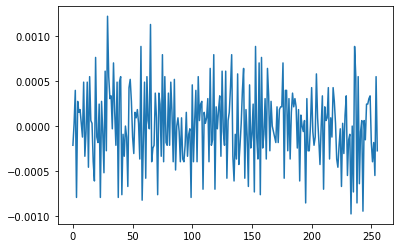

In [184]:
cdata1, cdata2 = get_samples(32768), get_samples(32768)

fig, ax = plt.subplots()
data1 = np.real(cdata1[1,-128:])
data2 = np.real(cdata2[1,:128])
totlength = len(data1) + len(data2)
datatot = np.concatenate((data1,data2))
ax.plot(datatot)

In [10]:
base.radio.receiver?

In [11]:
base.radio?

In [12]:
base.radio.receiver.channel[0].adc_block.BlockStatus

{'SamplingFreq': 4.9152,
 'AnalogDataPathStatus': 1,
 'DigitalDataPathStatus': 801,
 'DataPathClocksStatus': 1,
 'IsFIFOFlagsEnabled': 3,
 'IsFIFOFlagsAsserted': 0}

In [185]:
base.radio.transmitter.channel[0].dac_block.MixerSettings

{'Freq': 1200.0,
 'PhaseOffset': 0.0,
 'EventSource': 0,
 'CoarseMixFreq': 0,
 'MixerMode': 2,
 'FineMixerScale': 1,
 'MixerType': 2}

In [14]:
base.radio.receiver.channel[0].adc_block.QMCSettings

{'EnablePhase': 0,
 'EnableGain': 0,
 'GainCorrectionFactor': 0.0,
 'PhaseCorrectionFactor': 0.0,
 'OffsetCorrectionFactor': 0,
 'EventSource': 0}

In [15]:
base.radio.receiver.channel[0].adc_block.CoarseDelaySettings

{'CoarseDelay': 0, 'EventSource': 0}

In [16]:
base.radio.receiver.channel[0].adc_block.NyquistZone

1

In [180]:
base.radio.receiver.channel[0].adc_block.MixerSettings

{'Freq': -1228.8,
 'PhaseOffset': 0.0,
 'EventSource': 2,
 'CoarseMixFreq': 0,
 'MixerMode': 3,
 'FineMixerScale': 1,
 'MixerType': 2}

In [25]:
help(base.radio.transmitter.channel[0])

Help on DacChannel in module rfsystem.hierarchies object:

class DacChannel(pynq.overlay.DefaultHierarchy)
 |  DacChannel(description, dac_tile=None, dac_block=None)
 |  
 |  Wrapper for the dac channel hierarchy.
 |  
 |  This wrapper assumes the following pipeline structure and naming
 |  
 |  amplitude_controller -> rfdc
 |  
 |  Attributes
 |  ----------
 |  dac_tile : xrfdc.dac_tile
 |      The channel's associated DAC Tile. Can be used by the user
 |      to directly control the tile.
 |      
 |  dac_block : xrfdc.dac_block
 |      The channel's associated DAC Block. Can be used by the user
 |      to directly control the block.
 |      
 |  control : transmitter.AmplitudeController
 |      The Amplitude Controller that enables/disables signal
 |      output gain.
 |  
 |  Method resolution order:
 |      DacChannel
 |      pynq.overlay.DefaultHierarchy
 |      pynq.overlay._IPMap
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, description, dac_til

In [22]:
base.radio.receiver.channel[0].adc_block.BlockStatus

{'SamplingFreq': 4.9152,
 'AnalogDataPathStatus': 1,
 'DigitalDataPathStatus': 801,
 'DataPathClocksStatus': 1,
 'IsFIFOFlagsEnabled': 3,
 'IsFIFOFlagsAsserted': 0}

In [87]:
help(base.radio.receiver.channel[0].adc_tile)

Help on RFdcAdcTile in module xrfdc object:

class RFdcAdcTile(RFdcTile)
 |  RFdcAdcTile(*args)
 |  
 |  Method resolution order:
 |      RFdcAdcTile
 |      RFdcTile
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  GetFIFOStatusObs(self, *EnablePtr)
 |  
 |  SetupFIFOBoth(self, Enable)
 |  
 |  SetupFIFOObs(self, Enable)
 |  
 |  __init__(self, *args)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from RFdcTile:
 |  
 |  DumpRegs(self)
 |  
 |  DynamicPLLConfig(self, source, ref_clk_freq, samp_rate)
 |  
 |  Reset(self)
 |  
 |  SetupFIFO(self, Enable)
 |  
 |  ShutDown(self)
 |  
 |  StartUp(self)
 |  
 |  ----------------------------------------------------------------------
 |  Readonly properties inherited from RFdcTile:
 |  
 |  ClockSource
 |  
 |  FIFOStatus
 |  
 |  PLLConfig
 |  
 |  PLLLockStatus
 |  
 |  -------------------------------

In [91]:
help(base.radio.receiver.channel)

Help on list object:

class list(object)
 |  list(iterable=(), /)
 |  
 |  Built-in mutable sequence.
 |  
 |  If no argument is given, the constructor creates a new empty list.
 |  The argument must be an iterable if specified.
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __iadd__(self, value, /)
 |      Implement self+=value.
 |  
 |  __imul__(self, value, /)
 |      Implement self*=value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate sign

In [15]:
# help(base.radio.receiver.channel[0].adc_block)
print(base.radio.receiver.channel[0].adc_block.DecimationFactor)
base.radio.receiver.channel[0].adc_block.DecimationFactor = 2
print(base.radio.receiver.channel[0].adc_block.DecimationFactor)

1
2


In [5]:
help(base.radio.receiver.channel[0].transfer)

Help on method transfer in module rfsystem.hierarchies:

transfer(packetsize) method of rfsystem.hierarchies.AdcChannel instance
    Returns a numpy array with inspected data of length packetsize.

